In [150]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import MDS
from PIL import Image
import os
import pingouin as pg
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

import ecoset
import categorization as cat
import utils

# Dataset
100 images from Ecoset + CUB200.
* Superordinate: 50 vehicles and 50 animals
* Basic: 25 cars, 25 busses, 25 dogs, 25 birds
* Subordinate: 5 species of birds

Images preprocessed by centering the features and resizing to 224x224.

In [2]:
# Load csv
catImgs = pd.read_csv("./deepCatsImages.csv")

# Rename cat columns
catImgs = catImgs.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)
catImgs.head()


,path,name,super,basic,sub
0,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0021_794938.jpg,animal,bird,CUB_005.Crested_Auklet
1,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0028_794951.jpg,animal,bird,CUB_005.Crested_Auklet
2,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0036_794905.jpg,animal,bird,CUB_005.Crested_Auklet
3,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0011_794927.jpg,animal,bird,CUB_005.Crested_Auklet
4,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0006_1813.jpg,animal,bird,CUB_005.Crested_Auklet


In [3]:
imgFile = "./images/deepCatsImages.npy"

if not os.path.exists(imgFile):
    # Preallocate array for images
    images = np.zeros((df.shape[0], 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in df.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        images[i] = img

    # Save images as a npy
    np.save(imgFile, images)
else:
    # Load images from npy
    print("Loading images from file...")
    images = np.load(imgFile)

print(images.shape)

Loading images from file...
(100, 224, 224, 3)


# Models and representations
Generate representations from AlexNet trained in Mehrer et al 2022. 
* 10 models are trained on Ecoset (basic-level categories)
* 10 models are trained on ImageNet (mixed levels of abstraction)

In [4]:
# Load example model
weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89"
model = ecoset.make_alex_net_v2(weights_path=weightPath)
model.summary()

2023-05-15 15:29:09.045620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:29:09.053740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:29:09.054129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 15:29:09.055121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 54, 54, 64)        23296     
                                                                 
 pool1 (MaxPooling2D)        (None, 26, 26, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 26, 26, 192)       307392    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 192)       0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 384)       663936    
         

In [5]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Get ecoset representations
ecosetReps = np.zeros((len(seeds), images.shape[0], 4096 * 5 * 5), dtype=np.float32)
for i, seed in enumerate(seeds):
    repFile = f"./representations/ecoset/seed{seed:02}_reps.npy"
    
    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(images)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    ecosetReps[i] = reps

ecosetReps.shape


Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 100, 102400)

In [6]:
# Get imagenet representations
imagenetReps = np.zeros((len(seeds), images.shape[0], 4096 * 5 * 5), dtype=np.float32)
for i, seed in enumerate(seeds):
    repFile = f"./representations/imagenet/seed{seed:02}_reps.npy"
    
    if not os.path.exists(repFile):
        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath,
                                        output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(images)
        # Flatten representation
        reps = reps.reshape(reps.shape[0], -1)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    imagenetReps[i] = reps

imagenetReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 100, 102400)

# Categorization
We use a LBA to simulate a category verification task where each model is a 
different participant. We perform the task in each level of abstraction. For 
each image, we calculate a drift rate to verify that that image belongs to its
category by calculating similarity of that image's representation with the 
similarity of every other image of the same category (GCM-like).

First, the superordinate-level.

In [58]:
criterion = 2
maxImgs = 4
performance = pd.DataFrame(
    columns=["seed", "model", "image", "category", "level", "response", "RT"]
)
for level in ["super", "basic", "sub"]:
    performance = pd.concat([
        performance,
        cat.simulate_cat_verification(
            reps = ecosetReps,
            imgInfo = catImgs,
            categoryCol = level,
            modelName = "ecoset",
            simFun = cat.gcm_sim,
            criterion = criterion,
            maxImgs = maxImgs
        )
    ])

    performance = pd.concat([
        performance,
        cat.simulate_cat_verification(
            reps = imagenetReps,
            imgInfo = catImgs,
            categoryCol = level,
            modelName = "imagenet",
            simFun = cat.gcm_sim,
            criterion = criterion,
            maxImgs = maxImgs
        )
    ])
print(performance.groupby(['model', 'level'])['response'].agg(lambda x: np.mean(x == 'yes')))
print(performance.groupby(['model', 'level'])['RT'].agg(['mean', 'std']))

model     level
ecoset    basic    0.995
          sub      1.000
          super    0.986
imagenet  basic    0.541
          sub      0.504
          super    0.442
Name: response, dtype: float64
                    mean       std
model    level                    
ecoset   basic  0.929209  0.021063
         sub    0.916683  0.012732
         super  0.941941  0.020783
imagenet basic  0.960944  0.024093
         sub    0.976365  0.017963
         super  0.957103  0.031896


# ANOVA Analysis
We treat each model as a different participant so we do a mixed effects ANOVA where we have a between subject factor of training set (Ecoset or Imagenet) and a within-subject factor of level of categorization (Superordinate, basic, subordiante).

In [59]:
# Add a subject column that is a combo of model and seed
performance['subject'] = performance['model'] + performance['seed'].astype(str)

# Group data by model and level
sbjData = (performance.groupby(['subject', 'model', 'level'])
    .agg({
        'response': [lambda x: np.mean(x == 'yes')],
        'RT': ['mean']
    })
    .reset_index()
)
sbjData.columns = sbjData.columns.droplevel(1)
sbjData = sbjData.rename(columns={
    'response': 'accuracy',
    'RT': 'RT'
})
sbjData.head()

,subject,model,level,accuracy,RT
0,ecoset1,ecoset,basic,0.99,0.929264
1,ecoset1,ecoset,sub,1.00,0.915254
2,ecoset1,ecoset,super,0.97,0.938670
3,ecoset10,ecoset,basic,1.00,0.927028
4,ecoset10,ecoset,sub,1.00,0.914120


In [60]:
pg.mixed_anova(
    sbjData,
    dv = 'accuracy',
    within = 'level',
    between = 'model',
    subject = 'subject'
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,3.720060,1,18,3.720060,1336.548503,2.410957e-18,0.986711,NaN
1,level,0.030773,2,36,0.015387,12.179420,9.122402e-05,0.403567,0.965785
2,Interaction,0.020280,2,36,0.010140,8.026385,1.310556e-03,0.308394,NaN


In [61]:
pg.mixed_anova(
    sbjData,
    dv = 'RT',
    within = 'level',
    between = 'model',
    subject = 'subject'
)

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.018932,1,18,0.018932,2429.046240,1.173250e-20,0.992644,NaN
1,level,0.000206,2,36,0.000103,31.716598,1.142562e-08,0.637948,0.506946
2,Interaction,0.005063,2,36,0.002532,780.832969,2.242319e-30,0.977467,NaN


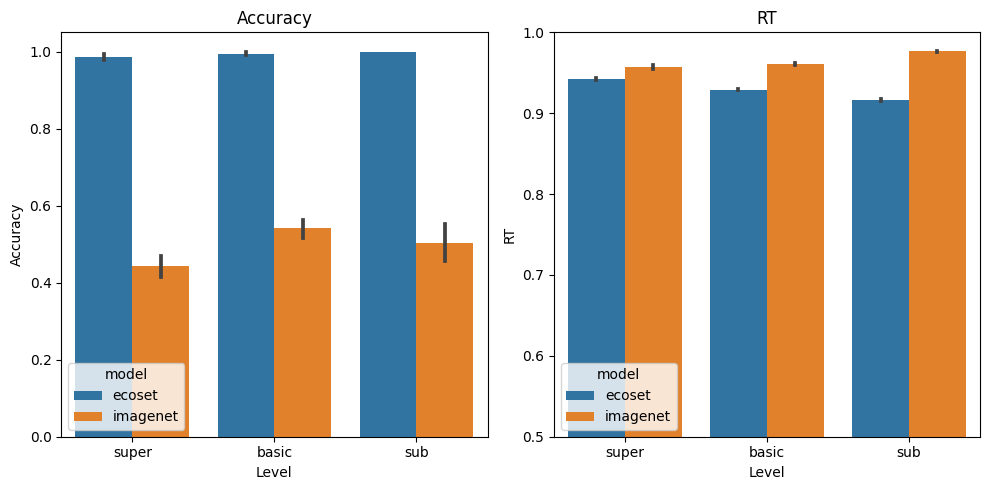

In [68]:
# Plot accuracy and RT
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Accuracy
sns.barplot(
    data = sbjData,
    x = 'level',
    y = 'accuracy',
    hue = 'model',
    ax = ax[0],
    order=['super', 'basic', 'sub']
)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Accuracy")

# RT
sns.barplot(
    data = sbjData,
    x = 'level',
    y = 'RT',
    hue = 'model',
    ax = ax[1],
    order=['super', 'basic', 'sub']
)
# Set y range
ax[1].set_ylim(0.5, 1)
ax[1].set_title("RT")
ax[1].set_xlabel("Level")
ax[1].set_ylabel("RT")

plt.tight_layout()
plt.show()

# MDS Analysis
We now look at how the categories are represented in the representational space. 

In [78]:
# Calculate similarity matrix for every image
ecosetSimMat = np.zeros((len(seeds), len(catImgs), len(catImgs)), dtype=np.float32)
imagenetSimMat = np.zeros((len(seeds), len(catImgs), len(catImgs)), dtype=np.float32)
for i in range(len(seeds)):
    ecosetSimMat[i] = squareform(pdist(ecosetReps[i], metric="euclidean"))
    imagenetSimMat[i] = squareform(pdist(imagenetReps[i], metric="euclidean"))

# Average across seeds
ecosetSimMat = np.mean(ecosetSimMat, axis=0)
imagenetSimMat = np.mean(imagenetSimMat, axis=0)
ecosetSimMat.shape

(100, 100)

In [111]:
catImgs

,path,name,super,basic,sub
0,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0021_794938.jpg,animal,bird,CUB_005.Crested_Auklet
1,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0028_794951.jpg,animal,bird,CUB_005.Crested_Auklet
2,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0036_794905.jpg,animal,bird,CUB_005.Crested_Auklet
3,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0011_794927.jpg,animal,bird,CUB_005.Crested_Auklet
4,./images/deepCats/animal/bird/CUB_005.Crested_...,Crested_Auklet_0006_1813.jpg,animal,bird,CUB_005.Crested_Auklet
...,...,...,...,...,...
95,./images/deepCats/vehicle/car/n02958343_3337.JPEG,n02958343_3337.JPEG,vehicle,car,NaN
96,./images/deepCats/vehicle/car/n02960352_10827....,n02960352_10827.JPEG,vehicle,car,NaN
97,./images/deepCats/vehicle/car/n04285008_8728.JPEG,n04285008_8728.JPEG,vehicle,car,NaN
98,./images/deepCats/vehicle/car/n03828020_3809.JPEG,n03828020_3809.JPEG,vehicle,car,NaN


In [124]:
# Color mapping
colorMap = {
    'dog': sns.color_palette(n_colors=4)[1],
    'car': sns.color_palette(n_colors=4)[2],
    'bus': sns.color_palette(n_colors=4)[3],
    'CUB_005.Crested_Auklet': sns.color_palette('mako', n_colors=5)[0], 
    'CUB_012.Yellow_headed_Blackbird': sns.color_palette('mako', n_colors=5)[1],
    'CUB_021.Eastern_Towhee': sns.color_palette('mako', n_colors=5)[2],
    'CUB_038.Great_Crested_Flycatcher': sns.color_palette('mako', n_colors=5)[3],
    'CUB_031.Black_billed_Cuckoo': sns.color_palette('mako', n_colors=5)[4],
}
# Get colors for each image
colors = [
    colorMap[row['sub']] if isinstance(row['sub'], str) else colorMap[row['basic']] 
    for _, row in catImgs.iterrows()
]

In [135]:
markerMap = {
    float('nan'): 'o', 
    'CUB_005.Crested_Auklet': 's', 
    'CUB_012.Yellow_headed_Blackbird': 's',
    'CUB_021.Eastern_Towhee': 'p',
    'CUB_038.Great_Crested_Flycatcher': 'p',
    'CUB_031.Black_billed_Cuckoo':'*',
}
catImgs['sub'].map(markerMap)

0     s
1     s
2     s
3     s
4     s
     ..
95    o
96    o
97    o
98    o
99    o
Name: sub, Length: 100, dtype: object

In [144]:
list(catImgs['sub'].map(markerMap))

['s',
 's',
 's',
 's',
 's',
 's',
 's',
 's',
 's',
 's',
 'p',
 'p',
 'p',
 'p',
 'p',
 'p',
 'p',
 'p',
 'p',
 'p',
 '*',
 '*',
 '*',
 '*',
 '*',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o']

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


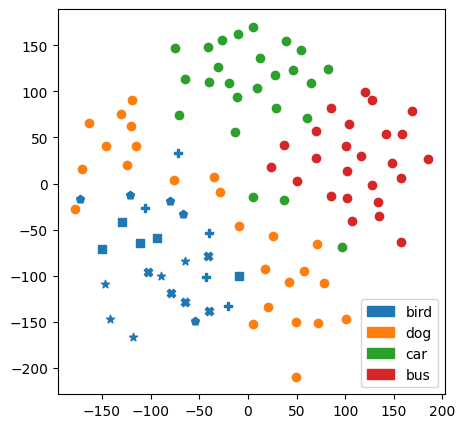

In [153]:
# Color mapping
colorMap = {
    'bird': sns.color_palette(n_colors=4)[0],
    'dog': sns.color_palette(n_colors=4)[1],
    'car': sns.color_palette(n_colors=4)[2],
    'bus': sns.color_palette(n_colors=4)[3]
}
colors = list(catImgs['basic'].map(colorMap))
# Market mapping
markerMap = {
    float('nan'): 'o', 
    'CUB_005.Crested_Auklet': 's', 
    'CUB_012.Yellow_headed_Blackbird': 'p',
    'CUB_021.Eastern_Towhee': 'P',
    'CUB_038.Great_Crested_Flycatcher': '*',
    'CUB_031.Black_billed_Cuckoo':'X',
}
markers = list(catImgs['sub'].map(markerMap))
# Create MDS for Ecoset
ecosetMDS = MDS(n_components=2, dissimilarity="precomputed")
ecosetSolution = ecosetMDS.fit_transform(ecosetSimMat)

# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot MDS
for i in range(len(catImgs)):
    ax.scatter(
        ecosetSolution[i, 0],
        ecosetSolution[i, 1],
        color = colors[i],
        marker = markers[i]
    )
    
legendHandles = [
    mpatches.Patch(color=colorMap['bird'], label='bird'),
    mpatches.Patch(color=colorMap['dog'], label='dog'),
    mpatches.Patch(color=colorMap['car'], label='car'),
    mpatches.Patch(color=colorMap['bus'], label='bus')
]
plt.legend(
    handles=legendHandles   
)

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


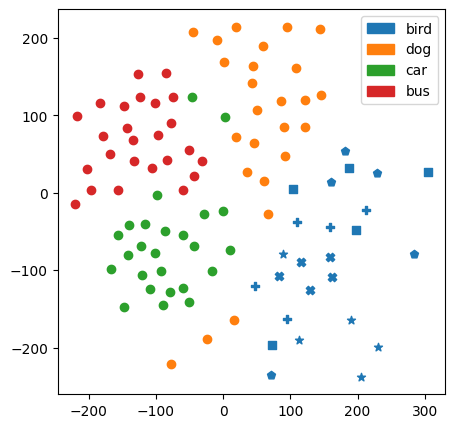

In [154]:
# Create MDS for Imagenet
imagenetMDS = MDS(n_components=2, dissimilarity="precomputed")
imagenetSolution = imagenetMDS.fit_transform(imagenetSimMat)

# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot MDS
for i in range(len(catImgs)):
    ax.scatter(
        imagenetSolution[i, 0],
        imagenetSolution[i, 1],
        color = colors[i],
        marker = markers[i]
    )

plt.legend(handles=legendHandles)